<a href="https://colab.research.google.com/github/MohsenJadidi/Automatic-Modulation-Classification-AMC/blob/master/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing the dataset (Copy from CNN.ipynb and merge cells)

In [2]:
import pickle
import numpy as np
fileName = 'RML2016.10a_dict.pkl'
with open("/content/drive/My Drive/Colab Notebooks/"+fileName,'rb') as f:
  data = pickle.load(f,encoding='bytes')
 
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
analog = [b'AM-DSB', b'AM-SSB', b'WBFM']

for mod_type, snr in data.keys():
    if (mod_type not in analog):      
        current_matrix = data[(mod_type, snr)]        
        total_examples += current_matrix.shape[0]
        for i in range(current_matrix.shape[0]):
            X.append(current_matrix[i])
            labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
    
X = np.array(X)         # First row is QPSK snr=2, seconde is PAM4 snr=8 , ...
labels = np.array(labels)

y = labels[:,0]

print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')  
# print(np.unique(labels[:,0]))

# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

snrList = [str(2*i-20) for i in range(20)]  # snrList = -20, -18, -16 , ... ,0, ... ,18
snr = snrList[19]
numberOfEachExamples = 1000
print("SNR :", snr)

output = [[labels[i*numberOfEachExamples, 0],y[i*numberOfEachExamples]] for i in range(int(X.shape[0]/numberOfEachExamples))]
output = dict(output)

X_snr = []
y_snr = []

for i in range(X.shape[0]):
    if labels[i,1] == snr:
        X_snr.append(X[i])
        y_snr.append(y[i])

X_snr = np.array(X_snr)
y_snr = np.array(y_snr)  

###### Splitting the dataset into the Training set and Test set ######
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 0.2, random_state = 0)
# The below line better for Cross_val part
#X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 1, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# StandardScaler expected <= 2.
#X_train = X_train.reshape([6400,256])
X_train = X_train.reshape([X_train.shape[0],256])
X_train = sc.fit_transform(X_train)
X_train = X_train.reshape([X_train.shape[0],2,128])
#X_test = X_test.reshape([1600,256])
X_test = X_test.reshape([X_test.shape[0],256])
X_test = sc.transform(X_test)
X_test = X_test.reshape([X_test.shape[0],2,128])

# Reshape
X_train = X_train.reshape(-1,2, 128, 1)   #Reshape for CNN -  (6400,2,128)->(6400,2,128,1)!!
X_test = X_test.reshape(-1,2, 128, 1)

loaded 160000 signal vectors into X(160000, 2, 128) and their corresponding labels into labels(160000, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


SNR : 18


## Import Module

In [3]:
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import add
from keras.layers import BatchNormalization, Activation
from keras.layers.convolutional import ZeroPadding2D

Using TensorFlow backend.


#Making ResNet0 model (four-convolutional-layer)
(Thesis :DEEP NEURAL NETWORK ARCHITECTURES FOR MODULATION CLASSIFICATION)

In [0]:
dout = 0.6

modelInput = Input(shape=(2,128,1))

x1 = Conv2D(filters = 256,kernel_size = (1,3), padding='same', activation = 'relu')(modelInput)
x1 = Dropout(rate=dout)(x1)

x2 = ZeroPadding2D(padding = (0,1))(x1)
x2 = Conv2D(filters = 256, kernel_size = (2,3), padding='valid' ,activation = 'relu')(x2)
x2 = Dropout(rate=dout)(x2)

x3 = Conv2D(filters = 80, kernel_size= (1,3), padding='same')(x2)
x3 = Dropout(rate=dout)(x3)

shortcut1 = (modelInput)
add1 = add([x3, shortcut1])
add1 = Activation('relu')(add1)

x4 = Conv2D(filters = 80, kernel_size= (1,3), padding='same', activation = 'relu')(add1)
x4 = Dropout(rate=dout)(x4)

x5 = Flatten()(x4)

x6 = Dense(output_dim = 128 , activation = 'relu')(x5)
x6 = Dropout(rate=dout)(x6)

out = Dense(output_dim = 8 , activation = 'softmax')(x6)

classifier = Model(inputs = modelInput, outputs = out)

classifier.summary()

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

print("Model Created!")

#logger = keras.callbacks.TensorBoard(log_dir="logs", write_graph=True, histogram_freq=5)


# Fitting model

In [0]:
batch = 64
epoch = 50
history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch, validation_data=(X_test, y_test))
#history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch)

# Prediction 

In [7]:
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_real = np.argmax(y_test, axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_real, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_test = classifier.evaluate(X_test, y_test)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)


6400/6400 [==============================] - 1s 213us/step
Acc Test :  0.8225
Acc Train :  0.99625


# Plot Confusion Matrix

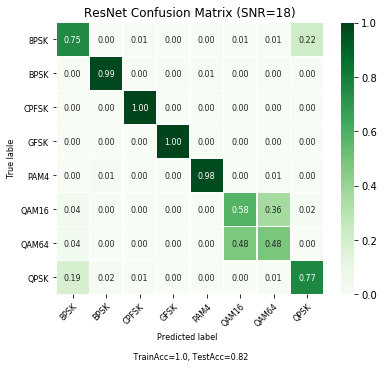

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
    
    
cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cmDataFrame, annot=True, annot_kws={"size": 8}, fmt='.2f', linewidths=.5, cmap="Greens")

plt.title(f"ResNet Confusion Matrix (SNR={snr})")
plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=8)
plt.ylabel("True lable", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)
fig = ax.get_figure()